In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
SEED = 1234
np.random.seed(SEED)
random.seed(SEED)

In [4]:
# Load data
url = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/spiral.csv"
df = pd.read_csv(url, header=0) # load
df.head()

,X1,X2,color
0,0.000000,0.000000,c1
1,-0.000457,0.001951,c1
2,0.001194,0.003826,c1
3,-0.000231,0.006008,c1
4,-0.000896,0.007966,c1


In [5]:
df = df.sample(frac=1).reset_index(drop=True) # shuffle
df.head()

,X1,X2,color
0,0.106737,0.114197,c1
1,0.311513,-0.664028,c1
2,0.019870,-0.703126,c1
3,-0.054017,0.508159,c3
4,-0.127751,-0.011382,c3


In [6]:
# Data Shapes
X = df[["X1", "X2"]].values
y = df["color"].values

print(f"X: {np.shape(X)}")
print(f"y: {np.shape(y)}")

X: (1500, 2)
y: (1500,)


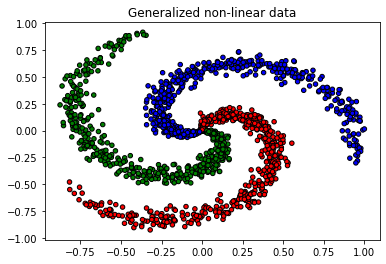

In [7]:
# plot data 
from turtle import color


plt.title("Generalized non-linear data")
colors = {"c1": "red", "c2": "green", "c3": "blue"}
plt.scatter(X[:, 0], X[:, 1], c=[colors[_y] for _y in y], edgecolors='k', s=20)
plt.show()

In [8]:
# split data
import collections
from sklearn.model_selection import train_test_split

In [9]:
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15

In [10]:
def train_val_test_split(X, y, train_size):
    """Split dataset into data splits."""
    X_train, X_, y_train, y_ = train_test_split(X, y, train_size=TRAIN_SIZE, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size=0.5, stratify=y_)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [11]:
# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X=X, y=y, train_size=TRAIN_SIZE)
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[0]} → {y_train[0]}")


X_train: (1050, 2), y_train: (1050,)
X_val: (225, 2), y_val: (225,)
X_test: (225, 2), y_test: (225,)
Sample point: [-0.63919105 -0.69724176] → c1


In [12]:
# label encoding
from sklearn.preprocessing import LabelEncoder

In [13]:
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y_train)
classes = list(label_encoder.classes_)
print(f"classes: {classes}")

classes: ['c1', 'c2', 'c3']


In [14]:
# convert labels to tokens
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)
y_val = label_encoder.transform(y_val)


In [15]:
print(f"y_train[0]: {y_train[0]}")

y_train[0]: 0


In [16]:
# class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print(f"counts: {counts}\nweights: {class_weights}")

counts: [350 350 350]
weights: {0: 0.002857142857142857, 1: 0.002857142857142857, 2: 0.002857142857142857}


In [17]:
# standardize data
from sklearn.preprocessing import StandardScaler

In [18]:
X_scalar = StandardScaler().fit(X_train)

In [19]:
# Apply scalar function to all X
X_train = X_scalar.transform(X_train)
X_val = X_scalar.transform(X_val)
X_test = X_scalar.transform(X_test)

print (f"X_test[0]: mean: {np.mean(X_test[:, 0], axis=0):.1f}, std: {np.std(X_test[:, 0], axis=0):.1f}")
print (f"X_test[1]: mean: {np.mean(X_test[:, 1], axis=0):.1f}, std: {np.std(X_test[:, 1], axis=0):.1f}")


X_test[0]: mean: 0.1, std: 0.9
X_test[1]: mean: 0.0, std: 1.0


In [49]:
X_train = X_train.float()
X_val = X_val.float()
X_test = X_test.float()

In [50]:
# check linear model
import torch
torch.manual_seed(SEED)

In [51]:
# model
from torch import nn
import torch.nn.functional as F

In [52]:
INPUT_DIM = X_train.shape[1]
HIDDEN_DIM = 100
NUM_CLASSES = len(classes)

In [54]:
class LinearModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(LinearModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x_in):
        z = self.fc1(x_in)
        z = self.fc2(z)
        return z

In [55]:
model = LinearModel(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, num_classes=NUM_CLASSES)
print(model.named_parameters)

<bound method Module.named_parameters of LinearModel(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)>


In [56]:
# Optimizer
from torch.optim import Adam

In [78]:
LEARNING_RATE = 1e-2
NUM_EPOCHS = 10
BATCH_SIZE = 32

In [94]:
# define loss
class_weights_tensor = torch.Tensor(list(class_weights.values()))
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [95]:
# Accuracy
def accuracy_fn(y_pred, y_true):
    n_correct = torch.eq(y_pred, y_true).sum().item()
    accuracy = (n_correct / len(y_pred)) * 100
    return accuracy


In [96]:
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

In [97]:
# Convert data to tensors
X_train = torch.Tensor(X_train)
y_train = torch.LongTensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.LongTensor(y_val)
X_test = torch.Tensor(X_test)
y_test = torch.LongTensor(y_test)


In [98]:
# Training
for epoch in range(NUM_EPOCHS):
    # Forward pass
    y_pred = model(X_train)

    # Loss
    loss = loss_fn(y_pred, y_train)

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    if epoch%1==0:
        predictions = y_pred.max(dim=1)[1] # class
        accuracy = accuracy_fn(y_pred=predictions, y_true=y_train)
        print (f"Epoch: {epoch} | loss: {loss:.2f}, accuracy: {accuracy:.1f}")


Epoch: 0 | loss: 0.78, accuracy: 54.3
Epoch: 1 | loss: 0.75, accuracy: 54.3
Epoch: 2 | loss: 0.73, accuracy: 54.5
Epoch: 3 | loss: 0.74, accuracy: 54.8
Epoch: 4 | loss: 0.74, accuracy: 53.0
Epoch: 5 | loss: 0.74, accuracy: 55.0
Epoch: 6 | loss: 0.74, accuracy: 54.9
Epoch: 7 | loss: 0.74, accuracy: 54.7
Epoch: 8 | loss: 0.73, accuracy: 54.2
Epoch: 9 | loss: 0.73, accuracy: 53.9


In [99]:
# evaluataion
import json
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support


In [100]:
def get_metrics(y_true, y_pred, classes):
    """Per-class performance metrics."""
    # Performance
    performance = {"overall": {}, "class": {}}

    # Overall performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    performance["overall"]["precision"] = metrics[0]
    performance["overall"]["recall"] = metrics[1]
    performance["overall"]["f1"] = metrics[2]
    performance["overall"]["num_samples"] = np.float64(len(y_true))

    # Per-class performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average=None)
    for i in range(len(classes)):
        performance["class"][classes[i]] = {
            "precision": metrics[0][i],
            "recall": metrics[1][i],
            "f1": metrics[2][i],
            "num_samples": np.float64(metrics[3][i]),
        }

    return performance


In [101]:
# Predictions
y_prob = F.softmax(model(X_test), dim=1)
print (f"sample probability: {y_prob[0]}")
y_pred = y_prob.max(dim=1)[1]
print (f"sample class: {y_pred[0]}")


sample probability: tensor([0.7991, 0.0706, 0.1302], grad_fn=<SelectBackward0>)
sample class: 0


In [102]:
# # Performance
performance = get_metrics(y_true=y_test, y_pred=y_pred, classes=classes)
print (json.dumps(performance, indent=2))


{
  "overall": {
    "precision": 0.5330404889228418,
    "recall": 0.5333333333333333,
    "f1": 0.532581594975483,
    "num_samples": 225.0
  },
  "class": {
    "c1": {
      "precision": 0.5,
      "recall": 0.5333333333333333,
      "f1": 0.5161290322580646,
      "num_samples": 75.0
    },
    "c2": {
      "precision": 0.5147058823529411,
      "recall": 0.4666666666666667,
      "f1": 0.4895104895104895,
      "num_samples": 75.0
    },
    "c3": {
      "precision": 0.5844155844155844,
      "recall": 0.6,
      "f1": 0.5921052631578947,
      "num_samples": 75.0
    }
  }
}


In [103]:
def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = plt.cm.Spectral

    X_test = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    y_pred = F.softmax(model(X_test), dim=1)
    _, y_pred = y_pred.max(dim=1)
    y_pred = y_pred.reshape(xx.shape)
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


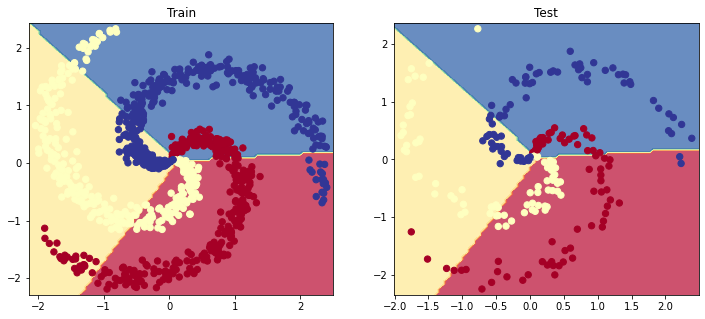

In [104]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.show()


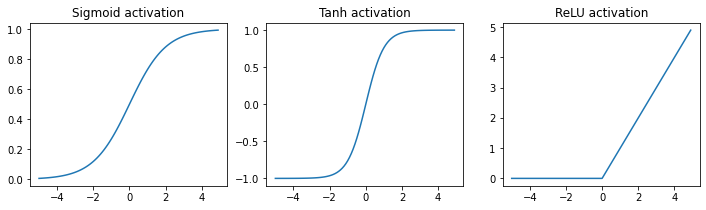

In [105]:
# activation functions
# Fig size
plt.figure(figsize=(12,3))

# Data
x = torch.arange(-5., 5., 0.1)

# Sigmoid activation (constrain a value between 0 and 1.)
plt.subplot(1, 3, 1)
plt.title("Sigmoid activation")
y = torch.sigmoid(x)
plt.plot(x.numpy(), y.numpy())

# Tanh activation (constrain a value between -1 and 1.)
plt.subplot(1, 3, 2)
y = torch.tanh(x)
plt.title("Tanh activation")
plt.plot(x.numpy(), y.numpy())

# Relu (clip the negative values to 0)
plt.subplot(1, 3, 3)
y = F.relu(x)
plt.title("ReLU activation")
plt.plot(x.numpy(), y.numpy())

# Show plots
plt.show()


In [111]:
# mlp non linear model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x_in):
        z = F.relu(self.fc1(x_in))
        z = self.fc2(z)
        return z

In [112]:
non_lin_model = MLP(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, num_classes=NUM_CLASSES)
print (non_lin_model.named_parameters)

<bound method Module.named_parameters of MLP(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)>


In [113]:
# Define Loss
class_weights_tensor = torch.Tensor(list(class_weights.values()))
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)


In [114]:
# Accuracy
def accuracy_fn(y_pred, y_true):
    n_correct = torch.eq(y_pred, y_true).sum().item()
    accuracy = (n_correct / len(y_pred)) * 100
    return accuracy


In [123]:
# Optimizer
optimizer = Adam(non_lin_model.parameters(), lr=LEARNING_RATE)


In [124]:
# Convert data to tensors
X_train = torch.Tensor(X_train)
y_train = torch.LongTensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.LongTensor(y_val)
X_test = torch.Tensor(X_test)
y_test = torch.LongTensor(y_test)


In [125]:
# Training
for epoch in range(NUM_EPOCHS*10):
    # Forward pass
    y_pred = non_lin_model(X_train)

    # Loss
    loss = loss_fn(y_pred, y_train)

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    if epoch%10==0:
        predictions = y_pred.max(dim=1)[1] # class
        accuracy = accuracy_fn(y_pred=predictions, y_true=y_train)
        print (f"Epoch: {epoch} | loss: {loss:.2f}, accuracy: {accuracy:.1f}")


Epoch: 0 | loss: 1.11, accuracy: 24.3
Epoch: 10 | loss: 0.67, accuracy: 55.4
Epoch: 20 | loss: 0.51, accuracy: 70.6
Epoch: 30 | loss: 0.39, accuracy: 88.5
Epoch: 40 | loss: 0.29, accuracy: 90.3
Epoch: 50 | loss: 0.22, accuracy: 93.4
Epoch: 60 | loss: 0.18, accuracy: 94.7
Epoch: 70 | loss: 0.15, accuracy: 95.9
Epoch: 80 | loss: 0.12, accuracy: 97.3
Epoch: 90 | loss: 0.11, accuracy: 97.7


In [126]:
# Predictions
y_prob = F.softmax(non_lin_model(X_test), dim=1)
y_pred = y_prob.max(dim=1)[1]


In [127]:
# # Performance
performance = get_metrics(y_true=y_test, y_pred=y_pred, classes=classes)
print (json.dumps(performance, indent=2))


{
  "overall": {
    "precision": 0.9913419913419913,
    "recall": 0.9911111111111112,
    "f1": 0.9911095305832148,
    "num_samples": 225.0
  },
  "class": {
    "c1": {
      "precision": 1.0,
      "recall": 0.9733333333333334,
      "f1": 0.9864864864864865,
      "num_samples": 75.0
    },
    "c2": {
      "precision": 1.0,
      "recall": 1.0,
      "f1": 1.0,
      "num_samples": 75.0
    },
    "c3": {
      "precision": 0.974025974025974,
      "recall": 1.0,
      "f1": 0.9868421052631579,
      "num_samples": 75.0
    }
  }
}


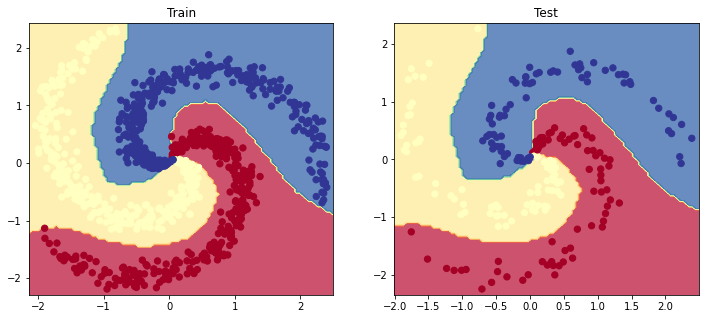

In [129]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=non_lin_model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=non_lin_model, X=X_test, y=y_test)
plt.show()


In [130]:
# Inputs for inference
X_infer = pd.DataFrame([{"X1": 0.1, "X2": 0.1}])


In [132]:
# Standardize
X_infer = X_scalar.transform(X_infer)
print (X_infer)


[[0.29906749 0.30544029]]


c:\Users\Akshay\Projects\ml_projects_with_mlops\venv\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [133]:
# Predict
y_infer = F.softmax(non_lin_model(torch.Tensor(X_infer)), dim=1)
prob, _class = y_infer.max(dim=1)
label = label_encoder.inverse_transform(_class.detach().numpy())[0]
print (f"The probability that you have {label} is {prob.detach().numpy()[0]*100.0:.0f}%")


The probability that you have c1 is 92%
